In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

from reconsnet.model.diffusion import DiffusionModule
from reconsnet.model.unet3d import Unet3DModule
from reconsnet.data.dataset import ClinicalDataset
from reconsnet.config import set_config_path
from reconsnet.util.coords import reproject
from reconsnet.data.postprocess import percentile_threshold, denoise_voxels
from pathlib import Path
from tqdm import tqdm

DATA_PATH = "/home/shared/uck-right"
CAMERA_GRID_SIZE = (60, 60, 60)

In [4]:
set_config_path(Path("../config"))

model_diffusion = DiffusionModule.load_from_checkpoint("/home/shared/model-weights/both.ckpt", lr=1e-4)
model_unet = Unet3DModule.load_from_checkpoint("../nooverfitting.ckpt", lr=1e-4)

reconstruct_diffusion = lambda x: model_diffusion.fast_reconstruct(*x, num_inference_steps=10, guidance=True)
reconstruct_unet = lambda x: F.sigmoid(model_unet.forward(x[0]))

ds = ClinicalDataset(DATA_PATH)

In [ ]:
def reconstruct_ix(i, reconstruct, model):
    (backprojection, _, p0, p1), xray0, xray1 = ds[i]
    p0 = p0.to(model.device)
    p1 = p1.to(model.device)
    backprojection = backprojection.to(model.device)
    hat = reconstruct((backprojection.unsqueeze(0), p0.unsqueeze(0).unsqueeze(0), p1.unsqueeze(0).unsqueeze(0)))
    hat = (hat - hat.min()) / (hat.max() - hat.min())

    threshold = percentile_threshold(hat, percentile=0.99)
    hat_bin = (hat > threshold).float().squeeze().cpu().numpy()
    hat_bin = denoise_voxels((hat > threshold).float(), min_neighbors=5).squeeze().cpu().numpy()
    return np.argwhere(hat_bin > 0), xray0.img, xray1.img


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.03it/s]


<Figure size 1000x3200 with 0 Axes>

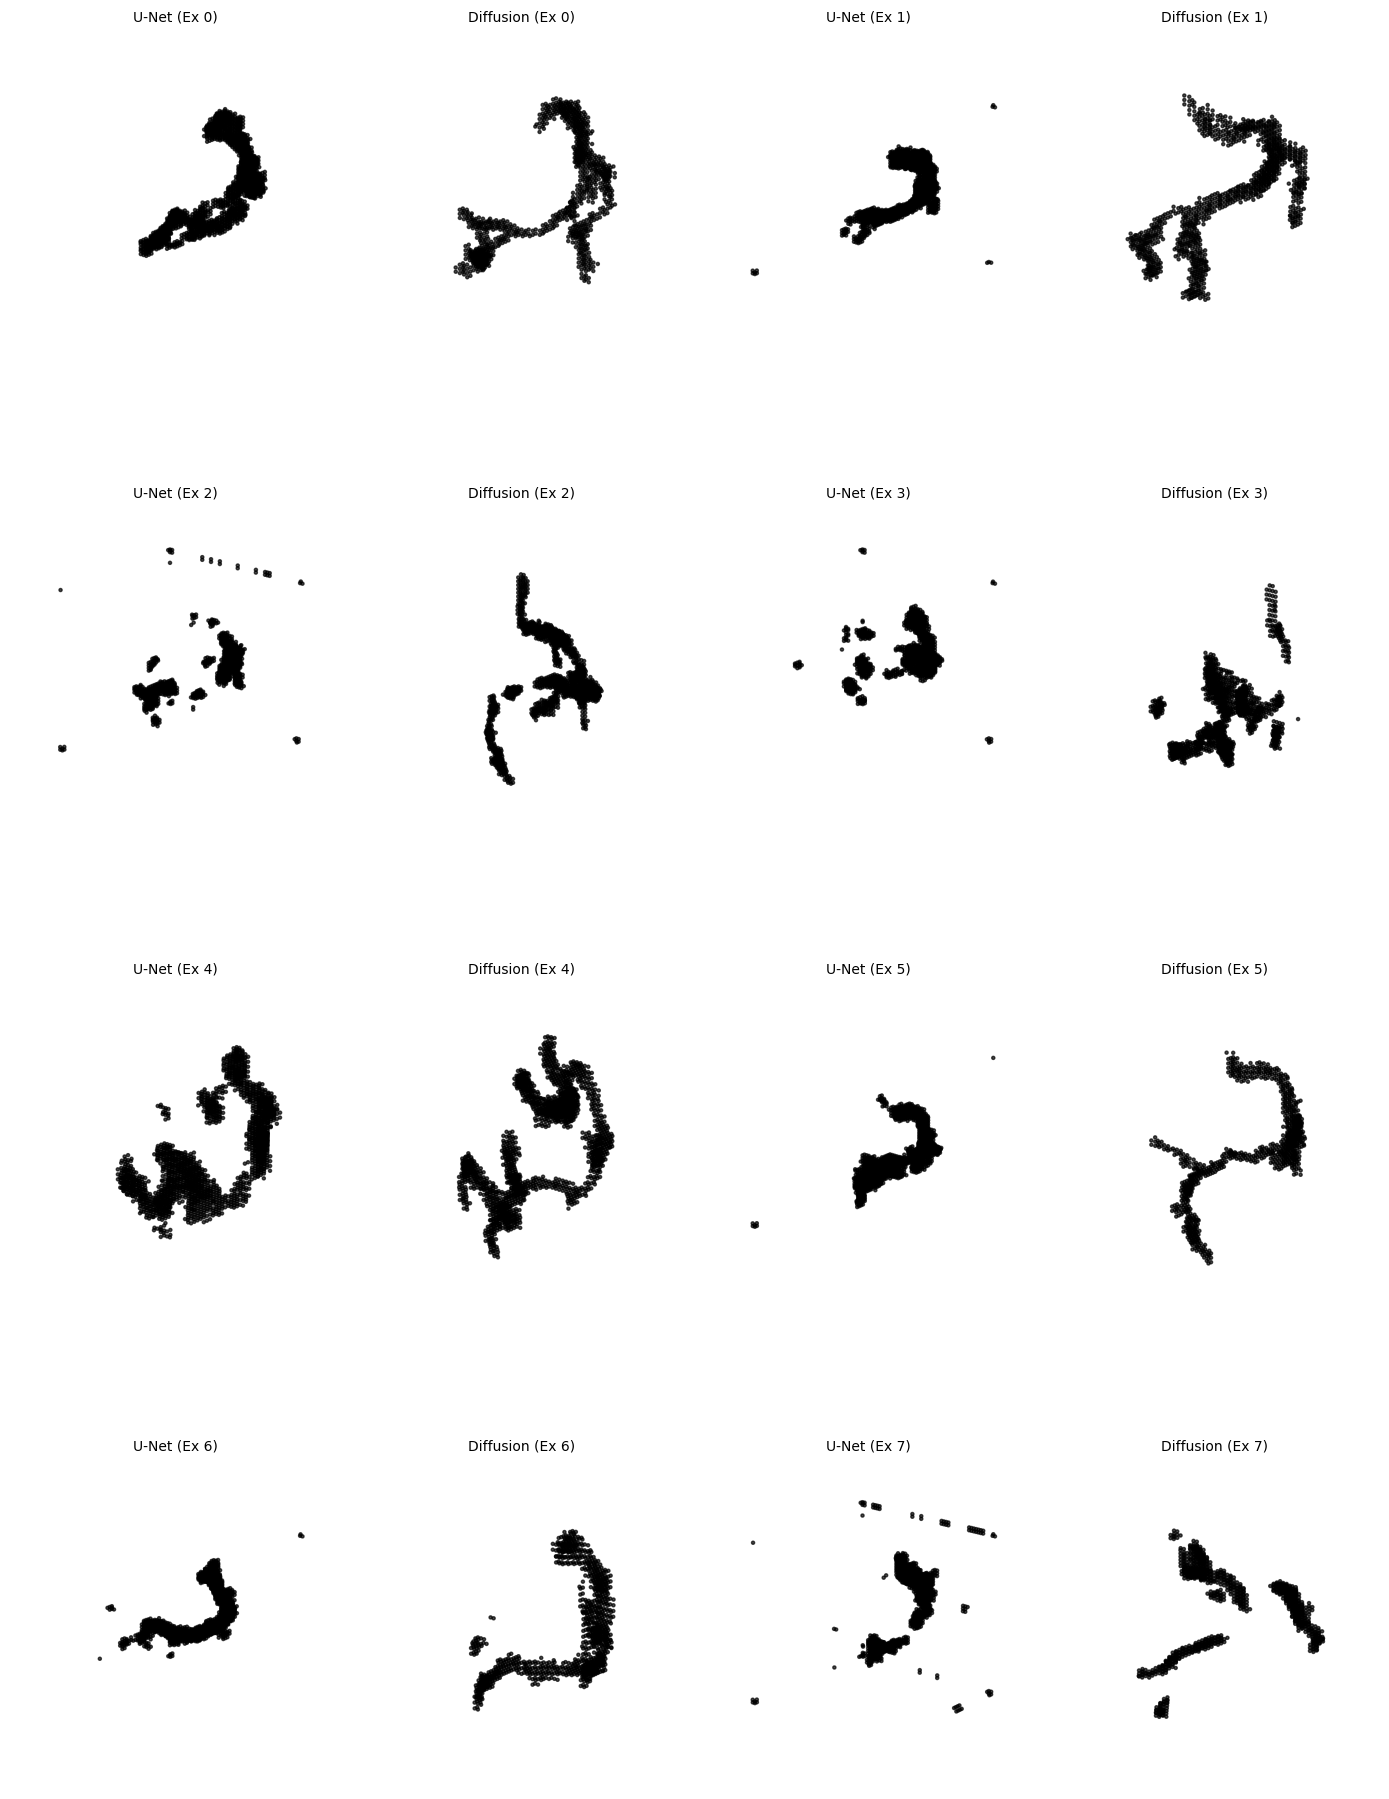

In [11]:
indices = [i for i in range(8)]
n = len(indices)
fig = plt.figure(figsize=(10, 4 * n))

n = len(indices)
ncols = 4
nrows = int(np.ceil(n / 2))
fig = plt.figure(figsize=(14, 5 * nrows))

for idx, i in enumerate(indices):
    col_offset = (idx % 2) * 2
    row = idx // 2
    ax_unet = fig.add_subplot(nrows, ncols, row * ncols + col_offset + 1, projection='3d')
    ax_diff = fig.add_subplot(nrows, ncols, row * ncols + col_offset + 2, projection='3d')

    points_u, _, _ = reconstruct_ix(i, reconstruct_unet, model_unet)
    ax_unet.scatter(points_u[:, 0], points_u[:, 1], points_u[:, 2],
                    s=5, c='black', alpha=0.7)
    ax_unet.set_title(f"U-Net (Ex {i})", fontsize=10)
    ax_unet.axis('off')
    ax_unet.view_init(elev=20, azim=40)
    ax_unet.set_box_aspect([1, 1, 1])

    points_d, _, _ = reconstruct_ix(i, reconstruct_diffusion, model_diffusion)
    ax_diff.scatter(points_d[:, 0], points_d[:, 1], points_d[:, 2],
                    s=5, c='black', alpha=0.7)
    ax_diff.set_title(f"Diffusion (Ex {i})", fontsize=10)
    ax_diff.axis('off')
    ax_diff.view_init(elev=20, azim=40)
    ax_diff.set_box_aspect([1, 1, 1])

plt.tight_layout()
plt.show()